# Importance Sampling
Ref: https://towardsdatascience.com/importance-sampling-introduction-e76b2c32e744

Importance sampling is an approximation method to find the Expectation of a function of a distribution, instead of the sampling method. It is often categorized as a **variance reduction algorithm**. It derives from a little mathematic transformation and is able to formulate the problem in another way. It helps in estimating the expectation, when the integration calculation is impractical (intractable integration). In this post, we are going to:

1. Learn the idea of importance sampling
2. Get deeper understanding by implementing the process
3. Compare results from different sampling distribution

## What is Importance Sampling?
Consider a scenario you are trying to calculate an expectation of function $f(x)$ , where $x \sim p_{\theta}(x)$ , subjected to some distribution $p_{\theta}(x)$ (e.g. ChatGPT can be a $p_{\theta}(x)$ here for language modelling, with $\theta$ as its parameters). We have the following Monte Carlo estimation of $E[f(x)]$ (for large $n$ --> Law of Large Numbers [LLN]):

$$E[f(x)]=\int f(x)p_{\theta}(x) dx \approx \frac{1}{n}\sum_i f(x_i)$$

The Monte Carlo sampling method is to simply sample $x$ from the distribution $p_{\theta}(x)$ and take the average of all samples to get an estimation of the expectation. 
Then here comes the problems -
 1. What if $p_{\theta}(x)$ is very hard/impossible to sample from? 
 2. What if it is inefficient to sample from $p_{\theta}(x)$, due to larger presence of rare events, resultingin choosing a very large $n$, thereby increasing computation?
 3. What if $p_{\theta}(x)$ is not normalized and we do not know the normalization constant?
 4. Are we able to estimate the expectation based on some known and easily sampled distribution?

The answer is **yes**. It comes from a simple transformation of the formula:

$$E[f(x)] = \int f(x)p_{\theta}(x) dx = \int f(x)\frac{p_{\theta}(x)}{q_{\phi}(x)}q_{\phi}(x) dx \approx \frac{1}{n}\sum_i f(x_i)\frac{p_{\theta}(x_i)}{q_{\phi}(x_i)}$$

Where $x$ is now sampled from $q_{\phi}(x)$ instead of $p_{\theta}(x)$, with the only condition that $q_{\phi}(x)$ must NOT be 0. The ratio $\frac{p_{\theta}(x_i)}{q_{\phi}(x_i)}$ is also called the *likelihood ratio* or *importance weight*.

The main difficult part to solve is to choose the **best** $q_{\phi}
(x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def f(x): # Sigmoid function
    return 1/(1+np.exp(-x))

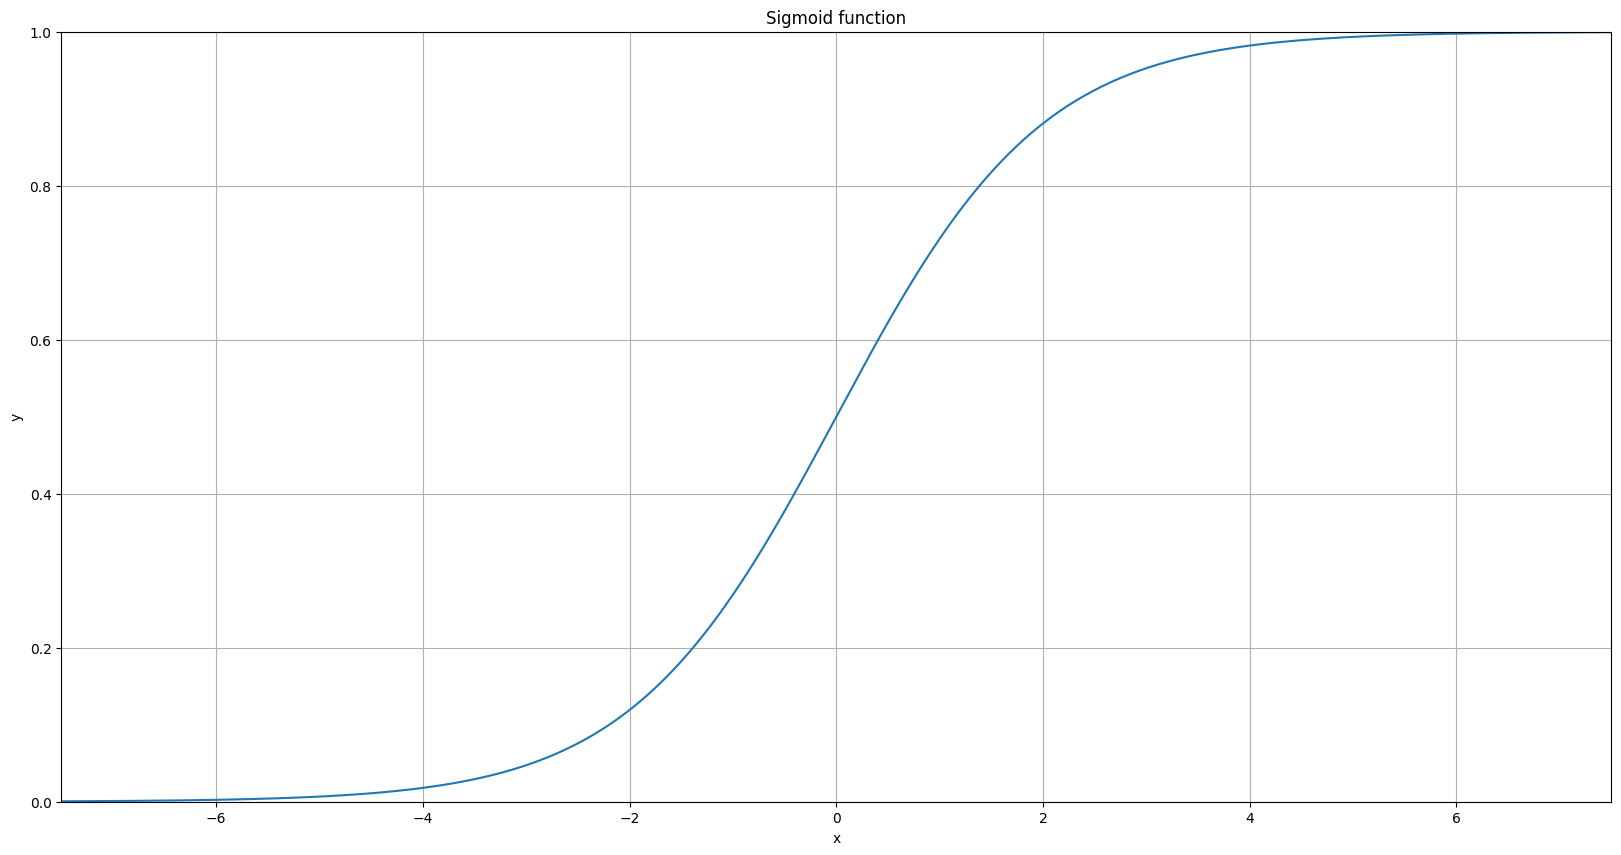

In [3]:
x = np.linspace(-7.5,7.5,500)

plt.figure(figsize=(20,10))
plt.plot(x,f(x))
plt.title('Sigmoid function')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-7.5,7.5)
plt.ylim(0,1)
plt.grid()

## Defining distriubtions $P(x)$ and $Q(x)$

In [4]:
def distribution(mu = 0, sigma = 1):
    distribution = stats.norm(mu, sigma)
    return distribution

In [5]:
# Number of Random Variables to be taken
n = 10000

# Target distribution
mu_p = 3
sigma_p = 2

# Approximator
mu_q = 3.5
sigma_q = 2.1

In [6]:
P = distribution(mu_p, sigma_p)
Q = distribution(mu_q, sigma_q)

`ppf()` function returns the $x$ value, when given the $y$ value of its CDF

In [7]:
P.ppf(0), P.ppf(0.5), P.ppf(1)

(-inf, 3.0, inf)

`pdf()` function returns the $y$ value of the PDF, when given the $x$ value

In [8]:
P.pdf(0), P.pdf(1.5), P.pdf(3), P.pdf(4.5), P.pdf(6) # Mean = 3, hence max value will be at x = 3

(0.06475879783294587,
 0.15056871607740221,
 0.19947114020071635,
 0.15056871607740221,
 0.06475879783294587)

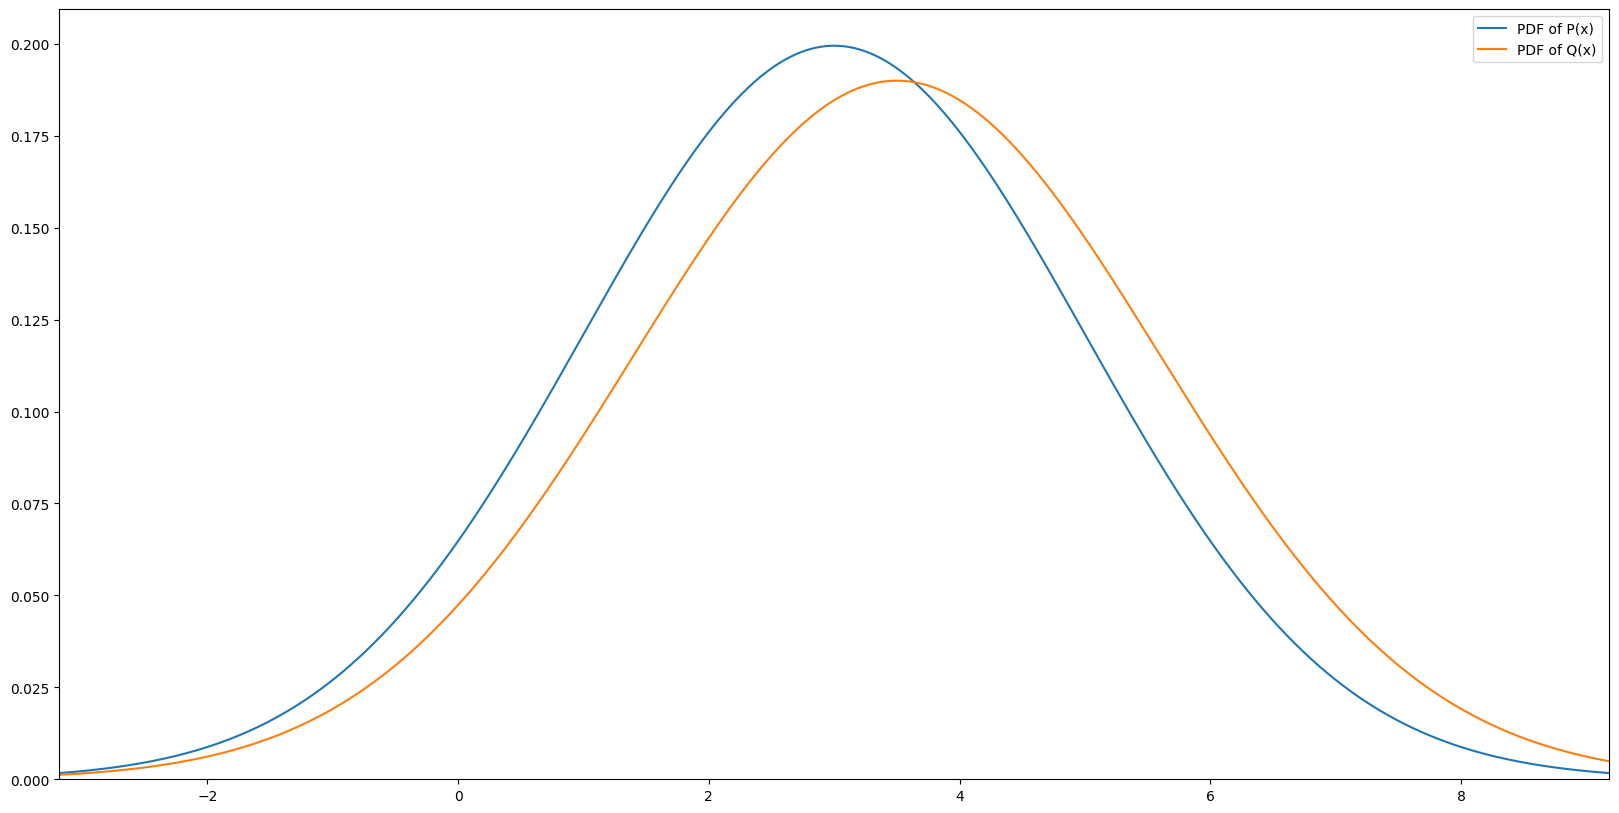

In [9]:
plt.figure(figsize=(20,10))

x = np.linspace(P.ppf(0.001), P.ppf(0.999), 1000)
plt.plot(x, P.pdf(x), label = 'PDF of P(x)')
plt.plot(x, Q.pdf(x), label = 'PDF of Q(x)')
plt.xlim(P.ppf(0.001), P.ppf(0.999))
plt.ylim(ymin=0)
plt.legend()

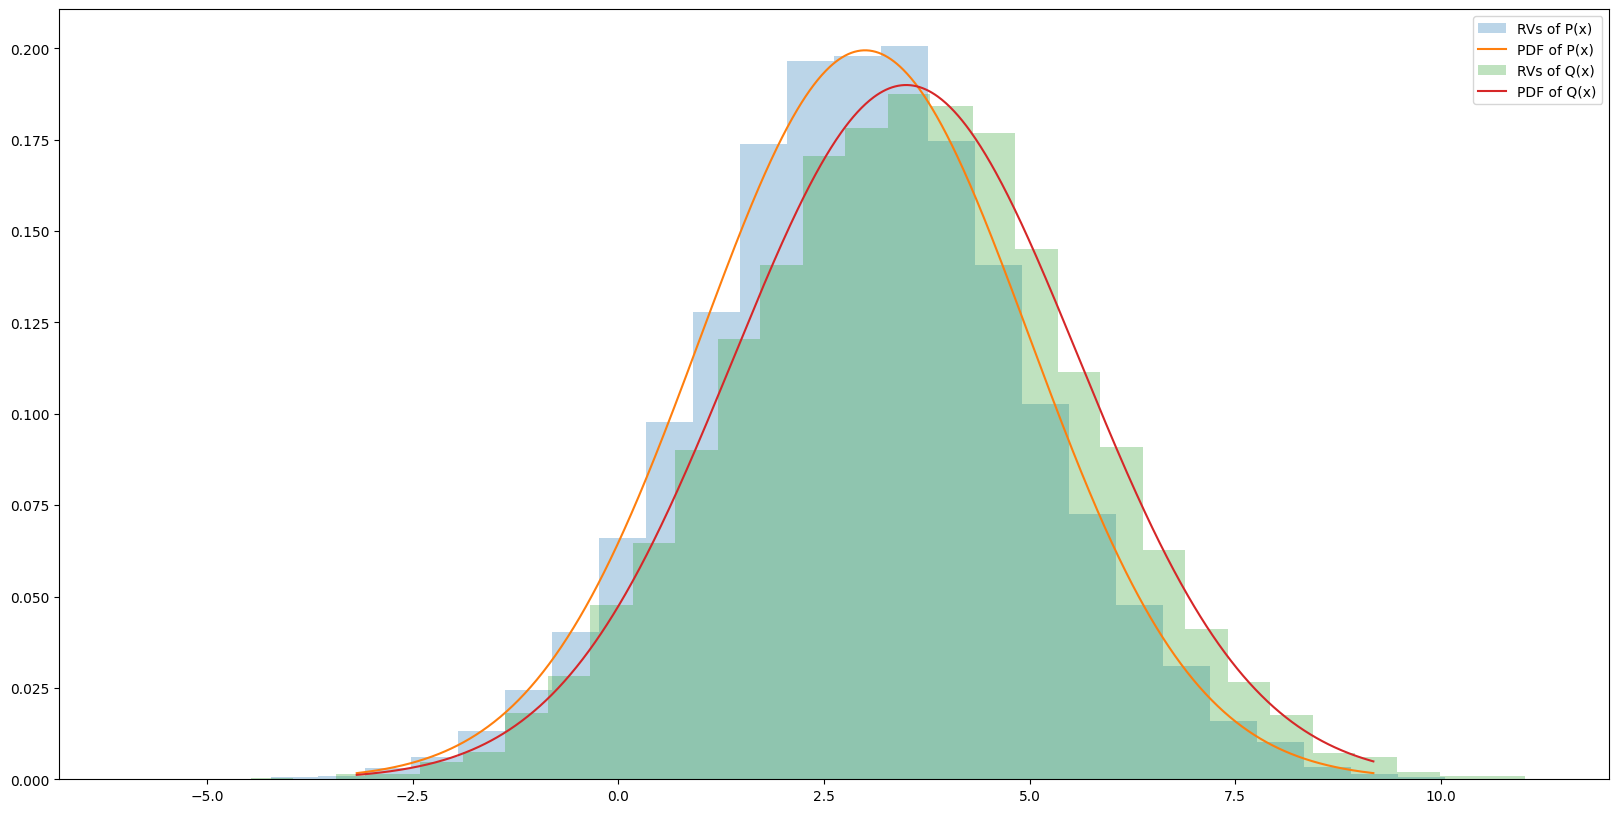

In [10]:
plt.figure(figsize=(20,10))

r = P.rvs(n) # Sampling values from the P(x) distribution
plt.hist(r, density = True, bins=30, alpha = 0.3, label = 'RVs of P(x)') # Put Density = True to obtain PDF of data
plt.plot(x, P.pdf(x), label = 'PDF of P(x)')

r1 = Q.rvs(n) # Sampling values from the P(x) distribution
plt.hist(r1, density = True, bins=30, alpha = 0.3, label = 'RVs of Q(x)') # Put Density = True to obtain PDF of data
plt.plot(x, Q.pdf(x), label = 'PDF of Q(x)')

plt.legend()

## Calculating Expectation $E[f(x)]$
Monte Carlo estimation -
$$E[f(x)]=\int f(x)P(x) dx \approx \frac{1}{n}\sum_i f(x_i)$$

### Integration

In [11]:
n = 100000
x = np.linspace(P.ppf(0.0001), P.ppf(0.9999), n)
dx = x[1]-x[0]

In [12]:
integration = 0
for x_value in x:
    integration+=f(x_value)*P.pdf(x_value)*dx
print(f'E[f(x)] = {integration}')

E[f(x)] = 0.8703050278464339


### Monte Carlo estimation

In [13]:
integration_sum = 0
x_i = P.rvs(n, random_state=10) # Sampling 100000 points from PDF of P(x)
integration_sum = np.sum(f(x_i))/n
print(f'E[f(x)] = {integration_sum}')

E[f(x)] = 0.8700122223056976


## Importance Sampling using $Q(x)$

$$E[f(x)] = \int f(x)P(x) dx = \int f(x)\frac{P(x)}{Q(x)}Q(x) dx \approx \frac{1}{n}\sum_i f(x_i)\frac{P(x_i)}{Q(x_i)}$$

Where $x$ is now sampled from $Q(x)$ instead of $P(x)$, with the only condition that $Q(x)$ must NOT be 0.

In [14]:
integration_approx = 0
x_i = Q.rvs(n, random_state=10) # Sampling 100000 points from PDF of P(x)
integration_approx = np.sum(f(x_i)*P.pdf(x_i)/Q.pdf(x_i))/n
print(f'E[f(x)] = {integration_approx}')

E[f(x)] = 0.8705634037652702
